# Notebook Goals
The goal of this notebook is to compare the outcomes of FHA and HOLC zones on home value, ownership, and segregation.  


In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('paper')

paper_cmap = {"A":"#5FCE72","B":"#0BC0ED","C":"#FFD419","D":"#FF4B19"}
paper_colors = LinearSegmentedColormap('paper_colors', paper_cmap)

import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import glob
import requests

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

import psycopg2  # (if it is postgres/postgis)
conn = psycopg2.connect(database="postgres", user="wonyoungso", password="",
    host="localhost")
cursor = conn.cursor()


from sqlalchemy import create_engine
engine = create_engine('postgresql://wonyoungso:@localhost:5432/postgres')

from geoalchemy2 import Geometry, WKTElement


import warnings
warnings.filterwarnings('ignore')


from patsylearn import PatsyModel, PatsyTransformer

import libpysal as ps

import statsmodels.api as sm
import statsmodels.stats as st



# 0. Get Data
### 0.1 Get data from HOLC cities

`chicago_historical` is the baseline dataset I'm working with which has the cross-walked census boundaries. The normalized data has been normalized by year, so they represent the number of standard deviations from the norm for that particulalr year. 

In [4]:
df_final = gpd.read_file('data/chicago_census_historical/chicago_census_historical.shp')

df_final = df_final.rename(columns={'asian': 'asian',
 'asian_pe_1': 'asian_perc_norm',
 'asian_perc': 'asian_perc',
 'black': 'black',
 'black_norm': 'black_norm',
 'black_pe_1': 'black_perc_norm',
 'black_perc': 'black_perc',
 'college': 'college',
 'college__1': 'college_perc_norm',
 'college_pe': 'college_perc',
 'gisjoin': 'gisjoin',
 'gisjoin_19': 'gisjoin_1940',
 'hispanic': 'hispanic',
 'hispanic_1': 'hispanic_perc_norm',
 'hispanic_p': 'hispanic_perc',
 'holc_grade': 'holc_grade',
 'homes': 'homes',
 'ln_homeval': 'ln_homeval_norm',
 'ln_income_': 'ln_income_norm',
 'ln_media_1': 'ln_median_homevalue_adj',
 'ln_median_': 'ln_median_income',
 'map_id': 'map_id',
 'median_h_1': 'median_homevalue_adj',
 'median_hom': 'median_homevalue',
 'median_i_1': 'median_income',
 'median_inc': 'median_income_adj',
 'other': 'other',
 'other_perc': 'other_perc',
 'owned_pe_1': 'owned_perc_norm',
 'owned_perc': 'owned_perc',
 'populati_1': 'population_density',
 'populati_2': 'population_density_norm',
 'populati_3': 'population_norm',
 'population': 'population',
 'unemploy_1': 'unemployed_perc',
 'unemploy_2': 'unemployed_perc_norm',
 'unemployed': 'unemployed',
 'white': 'white',
 'white_norm': 'white_norm',
 'white_pe_1': 'white_perc_norm',
 'white_perc': 'white_perc',
 'year': 'year'})


### 0.2 Feature creation
Need to create some extra features, including for later propensity scoring to find similarity between 'before' tracts. 


In [5]:
df_final['nonblack_perc'] = 1-df_final['black_perc']/df_final['population']

df_final['perc_college_10plus'] = [1 if x>0.10  else 0 for x in df_final['college_perc']]


# Need to create some extra features for the propensity scoring to increase similarity between 'before' tracts. 
df_final['perc_black_20plus'] = [1 if x>0.20  else 0 for x in df_final['black_perc']]
df_final['perc_college_10plus'] = [1 if x>0.10  else 0 for x in df_final['college_perc']]

# Create a point that represents roughly downtown is 
downtown = Point(-87.62,41.855)
df_final['dist_downtown'] = df_final.distance(Point(-87.62,41.855))


Create different treatment periods

In [6]:
df_final1 = df_final[df_final.year!=1950]
df_final1.loc[df_final1.year<=1940,'period']='pre'
df_final1.loc[(df_final1.year>1940)&
                   (df_final1.year<=1980),'period']='post'

df_final1.loc[(df_final1.year>1980),'period']='reversal'

### 0.3 Feature creation for Propensity Score Matching


In [7]:
# Create the D vs non-D FHA labels
df_final1['D_fha'] = df_final1.apply(lambda x: 'D' if x['fha_grade']=='D' else 'not_D_fha',axis=1)

### 0.4 Clean and standardize 

In [8]:
def decade_scaler(x):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(x)

def stand_data(df,features,groups = ['map_id','year']):
    for f in features: 
        df['{}_norm'.format(f)] = df[groups+features].groupby(groups).transform(lambda x: (x-x.mean())/x.std())[f]
    
    return df

In [9]:
def clean_tracts(df):
    df = df.replace([np.inf, -np.inf], np.nan)

    df = df[(df['ln_median_homevalue_adj']>0)&(df['owned_perc']>0)]
    df=df.drop_duplicates(['gisjoin','year'])
    return df

In [11]:
df_final1=clean_tracts(df_final1)

## Already did this earlier
# stand_features=['owned_perc','ln_median_homevalue_adj','white_perc','black_perc','unemployed_perc','asian_perc','hispanic_perc',
#                'population_density','population','ppl_per_home','dist_downtown']
# df_final = stand_data(df_final,stand_features)


# 1. Create Entropy and Information Theory Scores

In [10]:
def total_E(df,feature='black_prop'):
    tot = df['population'].sum()
    p=(df[feature]*df['population'])/tot+.00000001
    p = p.sum()
    E = -p*np.log2(p)-\
         (1-p)*np.log2(1-p)
        
    return E

In [11]:
def get_entropy(d): 
    
    '''
    Creates both the dissimiliarity measure and weighted entropy measure based on black 
    and non-black populations 
    '''
    
    d['e'] = 0
    d['e_w'] = 0
   
    for y in d['year'].unique():
        W = ps.weights.Queen.from_dataframe(d[d.year==y],geom_col='geometry',idVariable='gisjoin')
        
        #### Make sure the denominator is not zero
        d.loc[d['year']==y,'e'] =\
        d.groupby('year').apply(lambda x: -x['black_perc'].values * np.log2(x['black_perc'].values + .000001)-\
                                           x['nonblack_perc'].values * np.log2(x['nonblack_perc'].values + .000001))[y]
        W.transform = 'R'
        
        d_yr = d[d.year == y]
        for gisjoin in d_yr['gisjoin'].values:


            w_black_prop = np.average(list(d_yr[d_yr.gisjoin==gisjoin]['black_perc'].values)+
                                      list(d_yr.loc[(d_yr.gisjoin.isin(W.neighbors[gisjoin])),'black_perc']),
                                      weights=[1]+W.weights[gisjoin] )
            w_nonblack_prop = np.average(list(d_yr[d_yr.gisjoin==gisjoin]['nonblack_perc'].values)+
                                         list(d_yr.loc[(d_yr.gisjoin.isin(W.neighbors[gisjoin])),'nonblack_perc'].values),
                                         weights=[1]+ W.weights[gisjoin])
            try: 
                d.loc[(d['year']==y)&(d['gisjoin']==gisjoin),'e_w'] =-w_black_prop*np.log2(w_black_prop+.000001)-\
                                                w_nonblack_prop*np.log2(w_nonblack_prop+.000001)
                
            except (not W.neighbors[gisjoin]) or KeyError:
                print(gisjoin)
                d.loc[(d['year']==y)&(d['gisjoin']==gisjoin),'e_w'] = d.loc[(d['year']==y)&(d['gisjoin']==gisjoin),'e']
    return d

In [12]:
df_final2 = get_entropy(df_final1)

# 2. Prep for propensity score matching

### 2.1 Create a DF for PSM purposes

In [13]:
df_final_psm = df_final2[df_final2.period=='pre']
df_final_psm['fha_grade_psm'] = df_final_psm['fha_grade'].apply(lambda x: 'D' if x=='D' else 'not_D')

In [14]:
df_final_psm['black_perc_chng']= df_final_psm['black_perc'].diff()
df_final_psm['white_perc_chng']= df_final_psm['white_perc'].diff()
df_final_psm['population_density_chng_perc']= df_final_psm['population_density'].pct_change()
df_final_psm['ln_median_homevalue_adj_chng_perc']= df_final_psm['ln_median_homevalue_adj'].diff()
df_final_psm['owned_perc_chng']= df_final_psm['owned_perc'].diff()
df_final_psm['population_chng_perc']= df_final_psm['population'].pct_change()
df_final_psm['e_w_chng_perc']= df_final_psm['e_w'].pct_change()
df_final_psm['e_chng']= df_final_psm['e_w'].diff()



### 2.2  Remove all public data

In [15]:
public_data = gpd.read_file('data/chicago_housing/chicago_publichousing_historic.shp')

<AxesSubplot:>

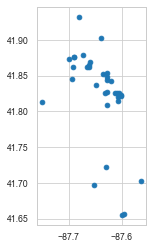

In [16]:
public_data.plot()

How many tracts intersect with public data? 

In [26]:
df_final_psm[df_final_psm.gisjoin.isin(gpd.sjoin(df_final_psm,
                                         public_data).gisjoin.unique())].shape[0]

54

Keep the tracts that don't have any public data. 

In [27]:
df_final_psm = df_final_psm[~df_final_psm.gisjoin.isin(gpd.sjoin(df_final_psm,
                                                                public_data).gisjoin.unique())]

### 2.3 Pre-Treatment
Select and average over pre-treatment period 

In [ ]:
df_final_psm = df_final_psm[(df_final_psm.period=='pre')]

In [ ]:
df_final_psm = df_final_psm.groupby(['period','gisjoin']).mean().reset_index()

### 2.4 Join back with FHA and HOLC Labels

In [ ]:
df_final_psm = df_final2[df_final2.year==1940][['gisjoin','fha_grade','holc_grade','geometry']].merge(df_final_psm,on='gisjoin')

### 2.5 Join with neighorhood boundaries

In [ ]:
neighorhoods = gpd.read_file('data/chicago_neighborhoods/Neighborhoods_2012b.shp')

In [ ]:
tract_n_labels = gpd.overlay(df_final_psm,neighorhoods[['PRI_NEIGH', 'SEC_NEIGH', 'geometry']].to_crs({'init': 'epsg:4326'}))
tract_n_labels['overlay_area']=tract_n_labels.geometry.area
tract_n_labels = tract_n_labels.sort_values(['gisjoin','overlay_area'],ascending=False)\
                                .groupby('gisjoin')\
                                .first()\
                                .reset_index()
            
df_final_psm = df_final_psm.merge(tract_n_labels[['gisjoin','PRI_NEIGH','SEC_NEIGH']],on='gisjoin',how='left')

# 3. Create a new DF that averages over periods

In [ ]:
df_final_avg = df_final2[df_final2.year==1940][['gisjoin','fha_grade','D_fha','holc_grade','geometry']]\
                                                    .merge(df_final2.groupby(['gisjoin','period'])\
                                                                   .mean()\
                                                                   .reset_index(),
                                                   on='gisjoin')
df_final_avg1 = df_final_avg.merge(df_final_psm[['white_perc_chng','black_perc_chng','population_density_chng_perc',
                                                 'population_chng_perc','ln_median_homevalue_adj_chng_perc',
                                                 'owned_perc_chng','e_w_chng_perc','gisjoin']],on='gisjoin')

In [ ]:
df_final_avg1_export = df_final_avg1.copy()
df_final_avg1_export.to_postgis('df_final_avg', engine, if_exists='replace')

----

# 4. Background Values and Charts for Paper

### 4.1 Test for spatial autocorrelation

In [ ]:
from esda.moran import Moran

for i in ['ln_median_homevalue_adj','owned_perc','e_w']:
    print(i)
    for y in df_final_avg1.period.unique():
        W = ps.weights.Queen.from_dataframe(df_final_avg1[df_final_avg1.period==y].to_crs(epsg=3857),ids='gisjoin',geom_col='geometry')
        mi = Moran(df_final_avg1[df_final_avg1.period==y][i].values, W, two_tailed=True)
        print("%.3f"%mi.I,"%.5f"%mi.p_norm, "%.3f"%mi.EI)

### 4.2 Test for temporal autocorrelation

Create a sorting order to autocorrelation purposes


In [ ]:
df_final_avg1.loc[df_final_avg1.period=='pre','per_order'] = 1
df_final_avg1.loc[df_final_avg1.period=='post','per_order'] = 2
df_final_avg1.loc[df_final_avg1.period=='reversal','per_order'] = 3

df_final_avg1 = df_final_avg1.sort_values(['gisjoin','per_order'])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

row = 0
fig,ax = plt.subplots(3,4,figsize=(24,14))
for i in ['ln_median_homevalue_adj','owned_perc','e_w']:
    counter = 0
    for grade in ['A','B','C','D']:
        
        plot_acf(df_final2[(df_final2['fha_grade']==grade)][i].fillna(0), 
                 lags=7,
                 ax =ax[row][counter],
                 title='Autocorr: Grade {} | {}'.format(grade,i))
        ax[row][counter].set_xlabel('Years after 1930')
        counter +=1
    row+=1

In [ ]:
row = 0
fig,ax = plt.subplots(3,4,figsize=(24,11))
for i in ['ln_median_homevalue_adj','owned_perc','e_w']:
    counter = 0
    for grade in ['A','B','C','D']:
        
        plot_acf(df_final_avg1[(df_final_avg1.fha_grade==grade)][i].fillna(0), 
                 lags=2,
                 ax =ax[row][counter],
                 title='Autocorr: Grade {} | {}'.format(grade,i))
        counter +=1
    row+=1

### 4.3 Trends over Time

This plot looks at the FHA labels and tracks them over time.

In [ ]:
sns.set_context("paper")

summary_features = [ 'population','population_density','unemployed_perc',\
              'black_perc','white_perc','asian_perc','hispanic_perc',
                 'college_perc','owned_perc','homes','median_homevalue_adj','e_w']

df_final_plots = df_final2.replace(0,np.nan)
f, axes = plt.subplots(4, 3, figsize=(14, 12), sharex=True)
sns.despine(left=True)
for i,each in enumerate(summary_features):
    if i==0: 
        l = 'brief'
    else: 
        l=False
    
    a1=i%4
    a2 = int(i/4)
    sns.lineplot(x='year',
                 y=each,
                 data=df_final_plots[df_final_plots.year!=1950],
                 hue='fha_grade',
                 hue_order=['A','B','C','D'],
                 palette={"A":"#5FCE72","B":"#0BC0ED","C":"#FFD419","D":"#FF4B19"},
                 legend=l,err_style='bars',
                 ax=axes[a1,a2],estimator=np.mean)


### 4.4 Pre-Treatment Choropleth


In [ ]:
fig,ax = plt.subplots(1,3,figsize=(20,8))

df_final_avg1[df_final_avg1.period=='pre'].plot('ln_median_homevalue_adj',cmap='viridis_r', ax=ax[0], legend=True, linewidth=0.1,scheme='quantiles')
df_final_avg1[df_final_avg1.period=='pre'].plot('owned_perc',cmap='viridis_r', ax=ax[1], legend=True, linewidth=0.1,scheme='quantiles')
df_final_avg1[df_final_avg1.period=='pre'].plot('e_w',cmap='viridis_r', ax=ax[2], legend=True, linewidth=0.1,scheme='quantiles')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()


ax[0].set_title('Pre-Treatment Log Median Home Value')
ax[1].set_title('Pre-Treatment Ownership Percentage')
ax[2].set_title('Pre-Treatment Spatially Weighted Entropy Index')


### 4.4 FHA/HOLC Comparison
- A count of which tracts are labeled the same vs different. 
- When different, how is it different? 
- Side by side map comparison

In [ ]:
df_fha_holc_test = df_final2[(df_final2.period=='pre') &
                           (df_final2.holc_grade.isin(['A','B','C','D']))][['fha_grade','holc_grade','gisjoin_1940']]
df_fha_holc_test['holc_grade_new'] = df_fha_holc_test['holc_grade'].apply(lambda x: x[0])

df_fha_holc_test['same'] = df_fha_holc_test.apply(lambda x: 'y' if x['holc_grade']==x['fha_grade'] else 'n',axis=1)

We can see that most of the FHA and HOLC labels are the same.

In [ ]:
df_fha_holc_test.groupby('same').count()

Here we can see how the two maps are different.

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,10))
    
for label, data in df_final2[(df_final2.year==1940)\
                             &(df_final2.fha_grade.isna()==False)].groupby('fha_grade'): 
    color = paper_cmap[label]
    data = gpd.GeoDataFrame(data,geometry='geometry',crs=4326).to_crs(epsg=3857)
    data.to_crs(epsg=3857).plot(color=color,ax=ax1, label=label, legend=False, linewidth=0.1,)
    
for label, data in df_final2[(df_final2.year==1940)\
                             &(df_final2.holc_grade.isna()==False)].groupby('holc_grade'): 
    color = paper_cmap[label]
    data = gpd.GeoDataFrame(data,geometry='geometry',crs=4326).to_crs(epsg=3857)
    data.plot(color=color,ax=ax2, label=label, legend=True, linewidth=0.1)
    
df_final2[(df_final2.year==1940)\
          &(df_final2.fha_grade.isna()==False)\
          &(df_final2.holc_grade!=df_final2.fha_grade)].to_crs(epsg=3857).plot(ax=ax1, facecolor="none", 
              edgecolor="gray", lw=0.7,linestyle='--')
df_final2[(df_final2.year==1940)\
          &(df_final2.fha_grade.isna()==False)\
          &(df_final2.fha_grade!=df_final2.holc_grade)].to_crs(epsg=3857).plot(ax=ax2, facecolor="none", 
              edgecolor="gray", lw=0.7,linestyle='--')

  
ax2.set_title('Tract Labels by HOLC Map')
ax1.set_title('Tract Labels by FHA Map')
ax1.set_axis_off()
ax2.set_axis_off()

----

# 5. Propensity Score Matching

Features to run the propensity scoring

In [ ]:
pscore_features= ['white_perc','white_perc_chng','black_perc','black_perc_chng',
                'population_density','population_density_chng_perc',
                'population','population_chng_perc',
                'college_perc','ln_median_homevalue_adj','ln_median_homevalue_adj_chng_perc',
                'owned_perc','owned_perc_chng','perc_college_10plus','perc_black_20plus','dist_downtown','e_w','e_w_chng_perc']

pscore_features_chng = ['ln_median_homevalue_adj_chng_perc',
                  'owned_perc_chng','e_w_chng_perc']


In [ ]:
df_final_psm['fha_grade_psm'] = df_final_psm.apply(lambda x: 'D' if x['fha_grade']=='D' else 'not_D',axis=1)

### 5.1 Estimate weights
Weights will probably be slightly different each time and resulting tracts that remain also different. 

In [ ]:
from sklearn import preprocessing

### Process the data
le = preprocessing.LabelEncoder()
scaler =preprocessing.MinMaxScaler()
std_scaler = preprocessing.StandardScaler()

### Fill missing values with the column mean
X = df_final_psm[pscore_features]
X = X.fillna(value=X.mean(axis=0)) 

##### Transform all to 0-1 scale.
X1 = pd.DataFrame(data=std_scaler.fit_transform(X,),columns=X.columns, index=X.index)

X1 = pd.merge(df_final_psm[['fha_grade_psm']],
              X1,left_index=True,right_index=True)
X1 = X1[pscore_features]

y = le.fit_transform(df_final_psm['fha_grade_psm'])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

rf= RandomForestClassifier()
rf1 = CalibratedClassifierCV(rf, cv=5,method='isotonic')


rf1 = rf1.fit(X1,y)
rf = rf.fit(X1,y)

print("Mean acccuracy of RF {:.3f}".format(rf1.score(X1, y)))


In [ ]:
### RF
y_probs = cross_val_predict(rf1, X1, y,cv=5,method='predict_proba')
df_final_psm['{}_prob'.format(le.classes_[0])]= y_probs[:,0]


In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X1.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

feature_importances

### 5.2 Turn probabilities into propensity weights

In [ ]:
df_final_psm.loc[df_final_psm['D_prob']==1,'D_prob']=.999999
df_final_psm.loc[df_final_psm['D_prob']==0,'D_prob']=.000001

In [ ]:
weights_name='weights3'

In [ ]:
df_final_psm[weights_name] = df_final_psm.apply(lambda x: 1/x['D_prob'] if x['fha_grade_psm']=='D' else 1/(1-x['D_prob']),axis=1)
df_final_psm[weights_name] = df_final_psm[weights_name].apply(lambda x: 100 if x>100 else x)

### 5.3 Filter years and PSM 

Filter for years that are not 1950 and also here's the place to filter for more stringent conditions such as 
- Tracts with non-black neighbors
- D-probs below a certain treshold. (using 25% here)
- Also find the non-D tracts that have a high prob of being D and were not??


** Filter for probabilties**

In [ ]:
##### create a DF with just the tract pairs
def final_df(weights_col,d_t=.9):
    D_thres = d_t

    df_allyrs= df_final_avg1[
                ((df_final_avg1['gisjoin'].isin(df_final_psm[(df_final_psm['D_prob']<=D_thres)\
                                                             &(df_final_psm['fha_grade_psm']=='D')].gisjoin.values))
                 | \
                 (df_final_avg1['gisjoin'].isin(df_final_psm[(df_final_psm['D_prob']>=(1-D_thres))\
                                                             &(df_final_psm['fha_grade_psm']!='D')].gisjoin.values))
                )
                     &\
                (df_final_avg1['gisjoin'].isin(df_final_psm[df_final_psm[weights_col]<=100].gisjoin.values))
               ]

    df_allyrs_norm=pd.merge(df_allyrs,df_final_psm[['gisjoin',weights_col,'PRI_NEIGH']],how='left',on='gisjoin')
    return(df_allyrs_norm)


In [ ]:
df_allyrs_norm = final_df(weights_name)

In [7]:

holc_weights= gpd.read_file('data/holc_weights/holc_weights.shp')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
chicago_boundary = gpd.read_file('data/chicago_boundary/geo_export_f05488dc-4f9d-49be-81e3-c094992d4c80.shp')

chicago_boundary.plot(ax=ax[0],color='white',edgecolor='#454545',linewidth =.4,)
chicago_boundary.plot(ax=ax[1],color='white',edgecolor='#454545',linewidth =.4,)

for label, data in df_allyrs_norm[df_allyrs_norm.period=='pre'].groupby('fha_grade'): 
    color = paper_cmap[label]
    data.plot(color=color,ax=ax[0], label=label, legend=True,linewidth=0.1)
    
for label, data in holc_weights[holc_weights.period=='pre'].groupby('holc_grade'): 
    color = paper_cmap[label]
    data.plot(color=color,ax=ax[1], label=label,linewidth=0.1)


ax[0].set_title('D-nD FHA tracts {} threshold'.format(0.9))
ax[1].set_title('D-nD HOLC tracts {} threshold'.format(0.9))
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].legend()

# plt.savefig('results/fha_holc_sidebyside_map.png',bbox_inches = 'tight',
#     pad_inches = 0)

### 5.4 Compare D against non-D and C, using weights

In [ ]:
def wavg(group, avg_name, weight_name):
    
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
#         return d.mean()
    except ZeroDivisionError:
        return d.mean()

This is what the two groups look like now once we've adjusted for the weights. 

#### 5.4.1 Find best threshold

In [ ]:
pscore_features_chng = ['ln_median_homevalue_adj_chng_perc', 'owned_perc_chng', 'e_w_chng_perc']


In [ ]:
import scipy
d_nd_dist = []
d_c_dist = []

thres_range = np.arange(0.1,1,.01)

for i in thres_range:
    df_allyrs_norm = final_df(weights_name,d_t=i)

    df_wavg = pd.DataFrame(columns = pscore_features_chng,index= ['D', 'not_D_fha'])
    for each in pscore_features_chng: 
        df_wavg.loc[:,each] = df_allyrs_norm[df_allyrs_norm.period=='pre'].groupby("D_fha").apply(wavg, each,weights_name).values
        
        
    df_wavg = df_wavg.transpose()
    
    d_nd_dist.append(scipy.spatial.distance.pdist(df_wavg.transpose())[0])


In [ ]:
plt.plot(thres_range,d_nd_dist,label='D-nD')
plt.title('Sum of differences between two FHA groups')
plt.legend()

In [ ]:
thres =.9

df_allyrs_norm = final_df(weights_name,d_t=thres)

### 5.5 Compare FHA and HOLC

In [ ]:
holc_weights = gpd.read_file('data/holc_weights/holc_weights.shp')

In [ ]:
t = df_allyrs_norm[(df_allyrs_norm.period=='pre') \
                   &(df_allyrs_norm.holc_grade.isin(['A','B','C','D']))][['fha_grade','holc_grade','gisjoin','geometry',weights_name]]

df_fha_holc_subgroup = pd.merge(t,df_final_psm[['gisjoin','D_prob']],on='gisjoin')
df_fha_holc_subgroup['holc_grade_new'] = df_fha_holc_subgroup['holc_grade'].apply(lambda x: x[0])
df_fha_holc_subgroup['same'] = df_fha_holc_subgroup.apply(lambda x: 'y' if x['holc_grade']==x['fha_grade'] else 'n',axis=1)


In [ ]:
holc_propensity_weights = holc_weights[holc_weights.period=='pre'].rename(columns={'D_prob':'holc_D_prob'})[['gisjoin','PRI_NEIGH','holc_D_prob']],
df_fha_holc_subgroup = pd.merge(df_fha_holc_subgroup,
                                holc_propensity_weights,
                                on='gisjoin',
                                how='left')

In [ ]:
df_fha_holc_subgroup.groupby(['same','fha_grade','holc_grade']).count()

#### Compare FHA and HOLC Weights

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
chicago_boundary = gpd.read_file('data/chicago_boundary/geo_export_f05488dc-4f9d-49be-81e3-c094992d4c80.shp')

chicago_boundary.plot(ax=ax[0],color='white',edgecolor='#454545',linewidth =.4,)
chicago_boundary.plot(ax=ax[1],color='white',edgecolor='#454545',linewidth =.4,)


pd.merge(df_allyrs_norm[(df_allyrs_norm.period=='pre')&(df_allyrs_norm.weights3<100)],df_final_psm[['gisjoin','D_prob']],on='gisjoin').plot('weights3',
                                                                                                              legend=True,
                                                                                                              ax=ax[0],
                                                                                                             cmap='GnBu',
                                                                                                              scheme='quantiles',
                                                                                                              linewidth=0.1)

holc_weights.plot('weights_holc',legend=True,ax=ax[1],cmap='GnBu',scheme='quantiles',linewidth=0.1)



ax[0].set_title('FHA Weights'.format(0.9))
ax[1].set_title('HOLC Weights'.format(0.9))
ax[0].set_axis_off()
ax[1].set_axis_off()


## Look at low probabilty D Tracts - FHA

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(12, 6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
chicago_boundary = gpd.read_file('data/chicago_boundary/geo_export_f05488dc-4f9d-49be-81e3-c094992d4c80.shp')

chicago_boundary.plot(ax=ax,color='white',edgecolor='#454545',linewidth =.4,)

df_fha_lowprobD = pd.merge(df_allyrs_norm[(df_allyrs_norm.period=='pre')&\
                        (df_allyrs_norm.weights3<100)&\
                        (df_allyrs_norm.fha_grade=='D')],df_final_psm[['gisjoin','D_prob']],on='gisjoin')

df_fha_lowprobD=df_fha_lowprobD[df_fha_lowprobD['D_prob']<.5]

neigh_fiveormorecount = df_fha_lowprobD.groupby('PRI_NEIGH').count().sort_values('gisjoin',ascending=False).reset_index().reset_index()

## Plot Neighborhoods that include these tracts
neighborhoods_example = neighorhoods[neighorhoods.PRI_NEIGH.isin(neigh_fiveormorecount.PRI_NEIGH)].to_crs({'init':'epsg:4326'})
neighborhoods_example['coords'] = neighborhoods_example['geometry'].apply(lambda x: x.representative_point().coords[:])
neighborhoods_example['coords'] = [coords[0] for coords in neighborhoods_example['coords']]
for idx, row in neighborhoods_example.iterrows():
    plt.annotate(s=row['PRI_NEIGH'], xy=row['coords'],
                 horizontalalignment='center',)
    
neighborhoods_example.plot(ax=ax,color='white',edgecolor='#454545',linewidth =.4,)


df_fha_lowprobD.plot('D_prob',
                      legend=True,
                      ax=ax,
                     cmap='viridis',
                      scheme='Quantiles',k=5,
                      linewidth=0.1)


ax.set_title('Probability of D label - FHA D Tracts'.format(0.9))
ax.set_axis_off()


## Tracts with different FHA and HOLC Labels

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
chicago_boundary = gpd.read_file('data/chicago_boundary/geo_export_f05488dc-4f9d-49be-81e3-c094992d4c80.shp')

chicago_boundary.plot(ax=ax,color='white',edgecolor='#454545',linewidth =.4,)


df_fha_diff=df_fha_holc_test_subgroup_paper[(df_fha_holc_test_subgroup_paper.same=='n')&\
                                (df_fha_holc_test_subgroup_paper.fha_grade=='D')]


## Plot Neighborhoods that include these tracts
neighborhoods_example = neighorhoods[neighorhoods.PRI_NEIGH.isin(df_fha_diff.PRI_NEIGH)].to_crs({'init':'epsg:4326'})
neighborhoods_example['coords'] = neighborhoods_example['geometry'].apply(lambda x: x.representative_point().coords[:])
neighborhoods_example['coords'] = [coords[0] for coords in neighborhoods_example['coords']]
for idx, row in neighborhoods_example.iterrows():
    plt.annotate(s=row['PRI_NEIGH'], xy=row['coords'],
                 horizontalalignment='center')
    
neighborhoods_example.plot(ax=ax,color='white',edgecolor='#454545',linewidth =.4,)


df_fha_diff.plot('D_prob',
                      legend=True,
                      ax=ax,
                     cmap='viridis',
                      scheme='Quantiles',k=5,
                      linewidth=0.1)


ax.set_title('Probability of D label - FHA D Tracts not graded D by HOLC'.format(0.9))
ax.set_axis_off()

# 6. DiD analysis

In [ ]:
plt.figure(figsize=(8,4))
df_final_psm[df_final_psm.fha_grade_psm=='D']['{}_prob'.format(le.classes_[0])].hist(bins=30,density=True,alpha=.5,label='D')
df_final_psm[df_final_psm.fha_grade_psm=='not_D']['{}_prob'.format(le.classes_[0])].hist(bins=30,density=True,alpha=.5,label='non-D')

plt.vlines(thres,0,16,linestyles='dashed',color='C0',lw=2.5,alpha=0.5,label='D threshold')
plt.vlines(1-thres,0,16,linestyles='dashed',color='C1',lw=2.5,alpha=0.5,label='non-D threshold')

plt.legend()
plt.title('Tracts Used Given Probability of D FHA Grade')

In [ ]:
df_wavg = pd.DataFrame(columns = pscore_features_chng,index= ['D', 'not_D_fha'])

for each in pscore_features_chng: 
    df_wavg.loc[:,each] = df_allyrs_norm[df_allyrs_norm.period=='pre'].groupby("D_fha").apply(wavg, each,weights_name).values

print(df_wavg.transpose())

## 2. DiD Model home values

### 2.2 Create dummies for different periods

In [ ]:
def treatment_period(x):
    if x <=1940: 
        return 'pre'
    elif x<=1980: 
        return 'post'
    else: 
        return 'reversal'

    
def get_dummies(df):

    period_dummy = pd.get_dummies(df['period'].astype(str),prefix='period')
    period_dummy = period_dummy[['period_pre','period_post','period_reversal']]

    grade_dummy = pd.get_dummies(df['fha_grade'],prefix=None)
    grade_dummy = pd.DataFrame(grade_dummy,index=df.index).rename(columns={'fha_grade':'grade_dummy'})

    grade_dummy = df['fha_grade'].apply(lambda x: 1 if x=='D' else 0)
    grade_dummy = pd.DataFrame(grade_dummy,index=df.index).rename(columns={'fha_grade':'D'})


    neigh_dummy = pd.get_dummies(df['PRI_NEIGH'].astype(str),prefix=None)
    neigh_dummy = pd.DataFrame(neigh_dummy).rename(columns={'PRI_NEIGH':'n_fe'})
    neigh_dummy= neigh_dummy.iloc[:,1:]
    
    tract_dummy = pd.get_dummies(df['gisjoin'].astype(str),prefix=None)
    tract_dummy = pd.DataFrame(tract_dummy).rename(columns={'gisjoin':'tract_fe'})
    tract_dummy= tract_dummy.iloc[:,1:]


    dummies_per = pd.concat([period_dummy, grade_dummy],axis=1)
    
    return df,period_dummy,grade_dummy,tract_dummy,neigh_dummy,dummies_per

In [ ]:
def get_interaction_dummies( period_dummy,dummies_per,grade_dummy):
    string1 = ""    
    
    
    for j in grade_dummy.columns: 
        for i in pd.concat([period_dummy],axis=1).columns: 
            string1= string1+ ("{}:{}+".format(i,j))
    
    per_grade_dummy = PatsyTransformer(string1[:-1], return_type="dataframe").fit_transform(dummies_per) ## Clipping off the last bit of the '+'

    return per_grade_dummy


In [ ]:
def get_feature_interaction_dummies( period_dummy1,features):
    string1 = ""
    
    features_per = pd.concat([period_dummy1,features],axis=1)

    
    for j in features.columns: 
        for i in pd.concat([period_dummy1],axis=1).columns: 
            string1= string1+ ("{}:{}+".format(i,j))
    
    per_feature_dummy = PatsyTransformer(string1[:-1], return_type="dataframe").fit_transform(features_per) ## Clipping off the last bit of the '+'

    return per_feature_dummy

### 6.1 Create regression summary functions

Create a function for running regressions

In [ ]:
def run_reg(df,weights_col,features,outcome,g_dum,p_dum,p_g_dum,n_dum,model='WLS',std=False, lag_x=False,lag_y=False,neigh=False):
    import datetime
    now = datetime.date.today()
    
    X1 = df[features]
    y1_1 = df[outcome]

    ### Adjust for spatial autocorrelation
    if lag_x==True: 
        X1_l = get_lags(df,features)
    if lag_y==True: 
        y1_l = get_lags(df,[y])

    ### Standardize optional
    if std==True: 
        X1 = (X1-X1.mean())/X1.std()
        y1_1 = (y1_1-y1_1.mean())/y1_1.std()
        if lag_x==True:
            X1_l = (X1_l-X1_l.mean())/X1_l.std()
        if lag_y==True: 
            y1_l = (y1_l-y1_l.mean())/y1_l.std()
    covariates = [X1,g_dum,p_dum,p_g_dum]
    
    if lag_x==True: 
        covariates.append(X1_l)
    if lag_y==True: 
        covariates.append(y1_l)
    if neigh==True: 
        covariates.append(n_dum)
        
        
    X1_1= pd.concat(covariates,ignore_index=False,axis=1)
    X1_1 = X1_1.fillna(value=X1_1.mean(axis=0))

    weights = df[weights_col]
    ####################
    ##       OLS      ##
    ####################
    if model=='OLS':
        mdl = sm.OLS(y1_1,X1_1,hasconst=True)
        results = mdl.fit()


        df['resid'] = results.resid
        df['y'] = y1_1
        df['y_pred'] = results.predict()

        print(results.summary())
        
        
    ####################
    ##       WLS      ##
    ####################
    if model=='WLS':
        mdl = sm.WLS(y1_1,X1_1,weights=weights,hasconst=False)
        results = mdl.fit()


        df['resid'] = results.resid
        df['y'] = y1_1
        df['y_pred'] = results.predict()

        print(results.summary())


    ####################
    ## Applies to all ##
    ####################

    # Display the autocorrelation plot of your time series
    from statsmodels.graphics import tsaplots

    fig = tsaplots.plot_acf(df['resid'], lags=2)
    plt.show()

    for i in ['resid']:
        print(i)
        for y in df.period.unique():
            W = ps.weights.Queen.from_dataframe(gpd.GeoDataFrame(df[df.period==y],
                                                                           geometry='geometry',
                                                                           crs={'init':'epsg:4326'}).to_crs(epsg=3857),
                                               geom_col='geometry',
                                               ids='gisjoin')
            W.transform='r'
            mi = Moran(df[df.period==y][i].values, W, two_tailed=True)
            print("%.3f"%mi.I,"%.5f"%mi.p_norm, "%.3f"%mi.EI)


    return df

### 6.2 Function for Creating Spatial Lags

In [ ]:
def get_lags(df,features):
    Xl_lst = []
    for y in df.period.unique():
        W = ps.weights.Queen.from_dataframe(gpd.GeoDataFrame(df[df.period==y],
                                                                       geometry='geometry',
                                                                       crs={'init':'epsg:4326'}).to_crs(epsg=3857),
                                           geom_col='geometry',
                                           ids='gisjoin')

        W.transform='r'
        Xl = ps.lag_spatial(W,df[df.period==y][features])
        Xl_lst.append(Xl)
    Xl_stack=np.vstack(tuple(Xl_lst))

    X_lag = pd.DataFrame(Xl_stack,
                 columns=['{}_l'.format(x) for x in features],
                 index = df.index)
    return X_lag

In [ ]:
df_allyrs_norm_subgroup,period_dummy1,grade_dummy,tract_dummy,neigh_dummy,dummies_per = get_dummies(df_allyrs_norm)
period_dummy =period_dummy1[['period_post','period_reversal']]


In [ ]:
per_grade_dummy = get_interaction_dummies(period_dummy,dummies_per,grade_dummy)

## 6.3 Model 1: Home Values
- Just 1930 and 1940 values in the independent variables

In [ ]:
weights_name = 'weights3'

In [ ]:
mdl1_features= ['white_perc','white_perc_chng','black_perc','black_perc_chng',
                'population_density','population_density_chng_perc',
                'population','population_chng_perc',
                'college_perc',
                'owned_perc','owned_perc_chng','perc_college_10plus','perc_black_20plus','dist_downtown','e_w']

# mdl1_features=[]

In [ ]:
df_allyrs_mdl1_1 = pd.merge(df_allyrs_norm[['per_order','period','gisjoin']+['ln_median_homevalue_adj','fha_grade','D_fha',weights_name]],
                                 df_final_psm[['gisjoin','geometry']+mdl1_features],
                                 on=['gisjoin'],how='left')


feat_dummies = get_feature_interaction_dummies(period_dummy1,df_allyrs_mdl1_1[mdl1_features])
df_allyrs_mdl1_1 = pd.concat([df_allyrs_mdl1_1,feat_dummies],axis=1)
mld1_1_results = run_reg(df_allyrs_mdl1_1,weights_name,feat_dummies.columns,'ln_median_homevalue_adj',
                         grade_dummy,period_dummy,per_grade_dummy,neigh_dummy,
                         model='WLS',std=True, lag_x=False,lag_y=False,neigh=False)

### 6.4 Model 2: Home Ownership

In [ ]:
mdl2_features= ['white_perc','white_perc_chng','black_perc','black_perc_chng',
                'population_density','population_density_chng_perc',
                'population','population_chng_perc',
                'college_perc',
                'ln_median_homevalue_adj','ln_median_homevalue_adj_chng_perc',
                'perc_college_10plus','perc_black_20plus','dist_downtown','e_w','e_w_chng_perc']


In [ ]:
df_allyrs_mdl2_1 = pd.merge(df_allyrs_norm[['per_order','period','gisjoin']+['owned_perc','fha_grade','D_fha',weights_name]],
                                 df_final_psm[['gisjoin','geometry']+mdl2_features],
                                 on=['gisjoin'],how='left')


feat_dummies = get_feature_interaction_dummies(period_dummy1,df_allyrs_mdl2_1[mdl2_features])

df_allyrs_mdl2_1 = pd.concat([df_allyrs_mdl2_1,feat_dummies],axis=1)

mld2_1_results = run_reg(df_allyrs_mdl2_1,weights_name,feat_dummies.columns,'owned_perc',
                         grade_dummy,period_dummy,per_grade_dummy,neigh_dummy,
                         model='WLS',std=True, lag_x=False,lag_y=False,neigh=False)

### 6.5 Model 3: Segregation

In [ ]:
mdl3_features= ['owned_perc','owned_perc_chng',
                'population_density','population_density_chng_perc',
                'population','population_chng_perc',
                'college_perc',
                'ln_median_homevalue_adj','ln_median_homevalue_adj_chng_perc','perc_college_10plus','dist_downtown']


#### Model 3.1: Not year-standardized

In [ ]:

df_allyrs_mdl3_1 = pd.merge(df_allyrs_norm_subgroup[['per_order','period','gisjoin']+['black_perc','e_w','fha_grade','D_fha',weights_name]],
                                 df_final_psm[['gisjoin','geometry']+mdl3_features],
                                 on=['gisjoin'],how='left')
feat_dummies = get_feature_interaction_dummies(period_dummy1,df_allyrs_mdl3_1[mdl3_features])

df_allyrs_mdl3_1 = pd.concat([df_allyrs_mdl3_1,feat_dummies],axis=1)

mld3_1_results = run_reg(df_allyrs_mdl3_1,weights_name,feat_dummies.columns,'e_w',
                         grade_dummy,period_dummy,per_grade_dummy,neigh_dummy,model='WLS',
                         std=True, lag_x=False,lag_y=False,neigh=True)
